In [1]:
import os

import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import seaborn as sns
import gpytorch
import torch

from REStats.utils import load_SCADA, filter_outliers, downsample, standardize
from REStats.plots import save_figs
from REStats.models import calc_iec_power_curve, power_curve

In [2]:
sns.set_theme()

In [3]:
figs = {}
SAVE_FIGS = True

In [4]:
wt = load_SCADA(2020)
cut_in = 2.0
cut_out = 18.0
wt = wt[(wt.wind_speed >= cut_in) & (wt.wind_speed < cut_out)]

In [5]:
# 1. Filter outliers
wt_filtered = filter_outliers(wt)

# 2. Downsample to 1h
wt_input = downsample(wt_filtered)
wt_input = wt_input.dropna()

# 3. Standardize
wt_std = standardize(wt_input)

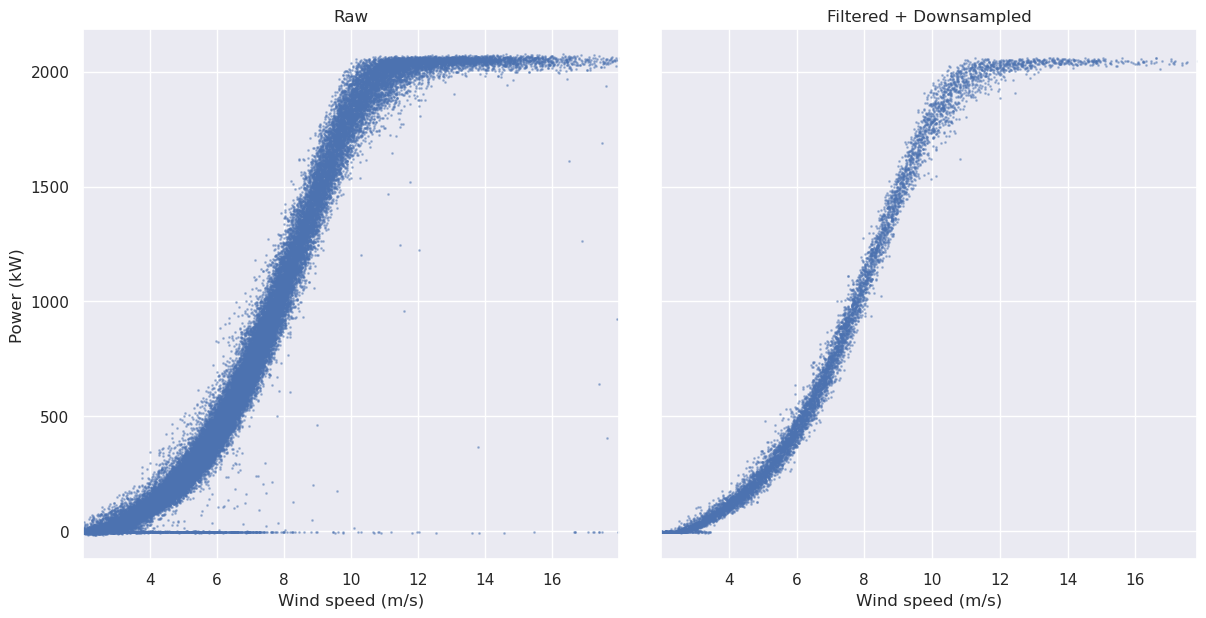

In [6]:
filtered_pc, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
filtered_pc.tight_layout()
axes[0].set_ylabel("Power (kW)")
for ax in axes:
    ax.set_xmargin(0)
    ax.set_xlabel("Wind speed (m/s)")

axes[0].set_title("Raw")
axes[1].set_title("Filtered + Downsampled")
axes[0].scatter(wt.wind_speed, wt.power, s=1, alpha=0.4)
axes[1].scatter(wt_input.wind_speed, wt_input.power, s=1, alpha=0.4)

figs["filtered_pc"] = filtered_pc

In [7]:
kbd = KBinsDiscretizer(n_bins=20, encode="ordinal")
bins = kbd.fit_transform(wt_input.wind_speed.to_numpy()[:, None])

train, test = train_test_split(wt_input, stratify=bins, train_size=800, test_size=1000, random_state=1)

train["power_std"] = (train.power - train.power.mean())/train.power.std()

train.head()

,wind_speed,wind_dir,power,turbulence_intensity,power_std
Date,,,,,
2020-08-12 12:00:00,3.733950,109.233234,63.212564,0.042896,-1.012178
2020-06-29 00:00:00,8.845966,227.648191,1401.390912,0.013921,1.000249
2020-10-16 12:00:00,3.839071,50.634728,101.696309,0.034614,-0.954304
2020-01-30 23:00:00,8.540635,242.486730,1313.503924,0.017304,0.868080
2020-04-02 00:00:00,6.170081,289.078997,437.647093,0.021170,-0.449083


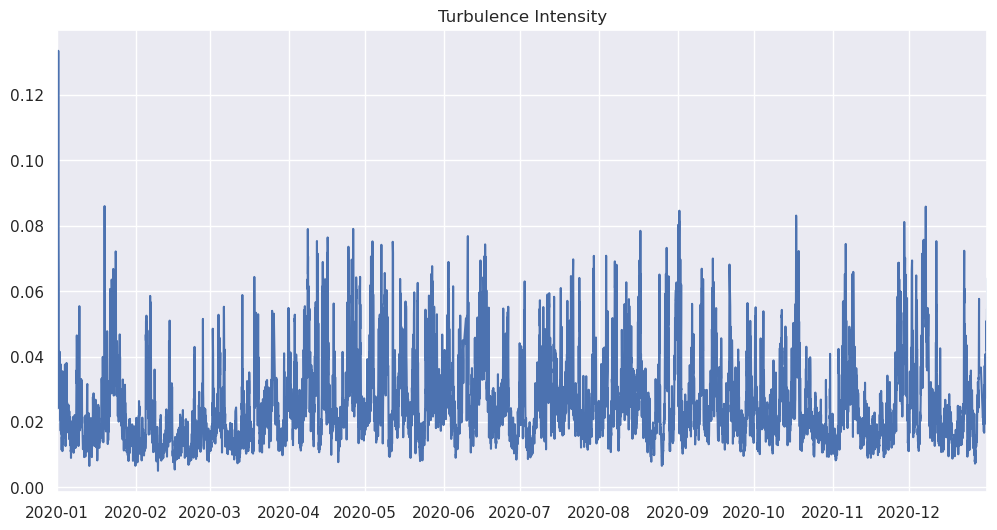

In [8]:
ti_fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xmargin(0)

ax.set_title("Turbulence Intensity")
wt_sort = wt_input.sort_index()
ax.plot(wt_sort.index, wt_sort.turbulence_intensity)

figs["TI"] = ti_fig

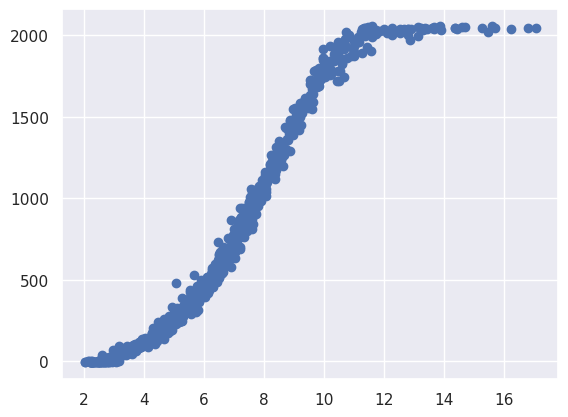

In [9]:
plt.scatter(train.wind_speed, train.power)

## IEC Method

In [10]:
kbd = KBinsDiscretizer(n_bins=20, encode="ordinal")
bins = kbd.fit_transform(wt_input.wind_speed.to_numpy()[:, None])

iec_train, iec_test = train_test_split(wt_input, stratify=bins, test_size=1000, random_state=1)


iec_pc = calc_iec_power_curve(iec_train)
iec_pc.head()

,wind_speed,wind_dir,power,turbulence_intensity
wind_speed,,,,
"(2.0, 2.5]",2.307589,187.212827,-0.947187,0.057697
"(2.5, 3.0]",2.745884,188.331790,10.425509,0.049759
"(3.0, 3.5]",3.247372,187.577623,43.483646,0.042566
"(3.5, 4.0]",3.754468,184.753003,91.701225,0.037206
"(4.0, 4.5]",4.257118,181.146111,144.717962,0.032503


In [11]:
iec_pred = [iec_pc.loc[ws, "power"] for ws in iec_test.wind_speed]

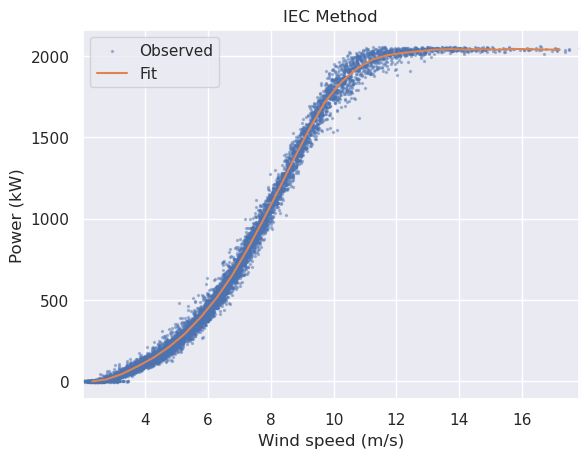

In [12]:
iec_pc_fig, ax = plt.subplots()
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.set_title("IEC Method")

ax.scatter(iec_train.wind_speed, iec_train.power, s=2, alpha=.4, color="C0", label="Observed")
ax.plot(iec_pc.wind_speed, iec_pc.power, color="C1", label="Fit")

ax.legend()

figs["iec_pc"] = iec_pc_fig

In [13]:
rmse = mean_squared_error(iec_pred, iec_test.power, squared=False)

print(f"IEC Test RMSE: {rmse} kW")

IEC Test RMSE: 56.54589984051903 kW


## Wind speed only

In [14]:
train_std = standardize(train)

X_train = torch.tensor(train_std.wind_speed)
y_train = torch.tensor(train_std.power_std)

model, likelihood = power_curve.fit(X_train, y_train)

Iter 1/100 - Loss: 0.765   lengthscale: [[0.6931471824645996]]   noise: 0.693
Iter 2/100 - Loss: 0.728   lengthscale: [[0.7443966269493103]]   noise: 0.644
Iter 3/100 - Loss: 0.690   lengthscale: [[0.7979324460029602]]   noise: 0.598
Iter 4/100 - Loss: 0.651   lengthscale: [[0.8535746335983276]]   noise: 0.554
Iter 5/100 - Loss: 0.612   lengthscale: [[0.9110979437828064]]   noise: 0.513
Iter 6/100 - Loss: 0.572   lengthscale: [[0.9702135920524597]]   noise: 0.474
Iter 7/100 - Loss: 0.532   lengthscale: [[1.0305521488189697]]   noise: 0.437
Iter 8/100 - Loss: 0.491   lengthscale: [[1.0916569232940674]]   noise: 0.403
Iter 9/100 - Loss: 0.450   lengthscale: [[1.1529864072799683]]   noise: 0.370
Iter 10/100 - Loss: 0.408   lengthscale: [[1.2139166593551636]]   noise: 0.340
Iter 11/100 - Loss: 0.365   lengthscale: [[1.2737394571304321]]   noise: 0.312
Iter 12/100 - Loss: 0.322   lengthscale: [[1.3316547870635986]]   noise: 0.286
Iter 13/100 - Loss: 0.279   lengthscale: [[1.386765956878662]

In [15]:
fit_x = np.linspace(cut_in, cut_out, 200)
fit_x_std = (fit_x - train.wind_speed.mean())/train.wind_speed.std()
fit_x_std = torch.tensor(fit_x_std, dtype=torch.float32)
fit_pred = power_curve.predict(model, likelihood, fit_x_std)

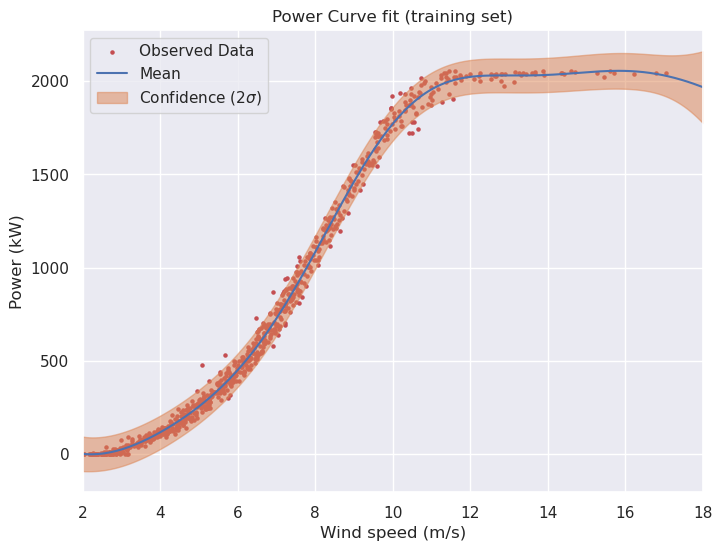

In [16]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_xmargin(0)
    ax.set_title("Power Curve fit (training set)")
    ax.set_xlabel("Wind speed (m/s)")
    ax.set_ylabel("Power (kW)")

    # Get upper and lower confidence bounds
    lower, upper = fit_pred.confidence_region()
    # Plot training data
    ax.scatter(train.wind_speed, train.power, s=5, color="C3")
    # Plot predictive means as blue line
    ax.plot(fit_x, fit_pred.mean.numpy() * train.power.std() + train.power.mean(), color="C0")
    # Shade between the lower and upper confidence bounds
    lower_tf = lower.numpy() * train.power.std() + train.power.mean()
    upper_tf = upper.numpy() * train.power.std() + train.power.mean()
    ax.fill_between(fit_x, lower_tf, upper_tf, color="C1", alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence (2$\sigma$)'])
    
figs["pc_train"] = f

In [17]:
test_sort = test.sort_values("wind_speed")
test_sort_std = standardize(test_sort, ref_df=train)
X_test_torch = torch.tensor(test_sort_std.wind_speed)

test_pred = power_curve.predict(model, likelihood, X_test_torch)

In [18]:
test_sort_std

,wind_speed,wind_dir,power,turbulence_intensity
Date,,,,
2020-05-27 06:00:00,-1.600352,1.135877,-1.108436,0.065364
2020-11-29 04:00:00,-1.567918,-1.764995,-1.108426,0.038496
2020-07-12 07:00:00,-1.561870,-2.625355,-1.108457,0.037348
2020-12-07 12:00:00,-1.559786,1.089108,-1.109826,0.063836
2020-08-17 03:00:00,-1.553780,-2.107846,-1.108608,0.054194
...,...,...,...,...
2020-08-25 15:00:00,3.467552,-0.167029,1.991086,0.008656
2020-02-10 22:00:00,3.470053,0.153538,1.989061,0.013211
2020-02-16 01:00:00,3.601011,-0.384563,1.948752,0.009991


In [19]:
test_pred_tf = test_pred.mean.numpy() * train.power.std() + train.power.mean()
test_rmse = mean_squared_error(test_pred_tf, test_sort.power, squared=False)

print(f"Test RMSE: {test_rmse} kW")

Test RMSE: 42.34729460152887 kW


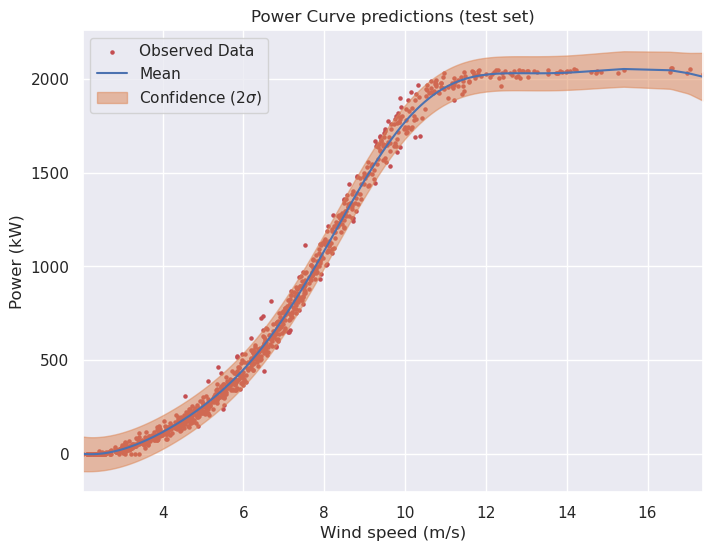

In [20]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_xmargin(0)
    ax.set_title("Power Curve predictions (test set)")
    ax.set_xlabel("Wind speed (m/s)")
    ax.set_ylabel("Power (kW)")
    
    # Get upper and lower confidence bounds
    lower, upper = test_pred.confidence_region()
    # Plot training data
    ax.scatter(test.wind_speed, test.power, s=5, color="C3")
    # Plot predictive means as blue line
    ax.plot(test_sort.wind_speed, test_pred_tf, color="C0")
    # Shade between the lower and upper confidence bounds
    lower_tf = lower.numpy() * train.power.std() + train.power.mean()
    upper_tf = upper.numpy() * train.power.std() + train.power.mean()
    ax.fill_between(test_sort.wind_speed, lower_tf, upper_tf, color="C1", alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence (2$\sigma$)'])
    
figs["pc_test"] = f

## Wind speed + direction w/ARD

In [21]:
X_test2 = torch.tensor(test_sort_std[["wind_speed", "wind_dir"]].values, dtype=torch.float32)

X_train2 = torch.tensor(train_std[["wind_speed", "wind_dir"]].values, dtype=torch.float32)
y_train2 = torch.tensor(train_std.power, dtype=torch.float32)

model2, likelihood2 = power_curve.fit(X_train2, y_train2, dims=2)
test_pred2 = power_curve.predict(model2, likelihood2, X_test2)

Iter 1/100 - Loss: 0.805   lengthscale: [[0.6931471824645996, 0.6931471824645996]]   noise: 0.693
Iter 2/100 - Loss: 0.764   lengthscale: [[0.7443966269493103, 0.7443966269493103]]   noise: 0.644
Iter 3/100 - Loss: 0.724   lengthscale: [[0.7978658676147461, 0.7979730367660522]]   noise: 0.598
Iter 4/100 - Loss: 0.683   lengthscale: [[0.8532861471176147, 0.8537418842315674]]   noise: 0.554
Iter 5/100 - Loss: 0.643   lengthscale: [[0.9103164076805115, 0.9115604162216187]]   noise: 0.513
Iter 6/100 - Loss: 0.602   lengthscale: [[0.9685474634170532, 0.9712812900543213]]   noise: 0.474
Iter 7/100 - Loss: 0.560   lengthscale: [[1.027525544166565, 1.0327541828155518]]   noise: 0.437
Iter 8/100 - Loss: 0.519   lengthscale: [[1.0867865085601807, 1.0958229303359985]]   noise: 0.403
Iter 9/100 - Loss: 0.476   lengthscale: [[1.1458765268325806, 1.1603209972381592]]   noise: 0.370
Iter 10/100 - Loss: 0.433   lengthscale: [[1.204351782798767, 1.226069450378418]]   noise: 0.340
Iter 11/100 - Loss: 0.

Iter 84/100 - Loss: -1.271   lengthscale: [[1.1791807413101196, 5.425545692443848]]   noise: 0.004
Iter 85/100 - Loss: -1.271   lengthscale: [[1.180275321006775, 5.463514804840088]]   noise: 0.004
Iter 86/100 - Loss: -1.271   lengthscale: [[1.1815983057022095, 5.500913619995117]]   noise: 0.004
Iter 87/100 - Loss: -1.271   lengthscale: [[1.182746410369873, 5.537745475769043]]   noise: 0.004
Iter 88/100 - Loss: -1.271   lengthscale: [[1.183373212814331, 5.574016094207764]]   noise: 0.004
Iter 89/100 - Loss: -1.271   lengthscale: [[1.1833107471466064, 5.609734058380127]]   noise: 0.004
Iter 90/100 - Loss: -1.271   lengthscale: [[1.182600736618042, 5.644911766052246]]   noise: 0.004
Iter 91/100 - Loss: -1.271   lengthscale: [[1.1814303398132324, 5.679566860198975]]   noise: 0.004
Iter 92/100 - Loss: -1.271   lengthscale: [[1.1800928115844727, 5.713717937469482]]   noise: 0.004
Iter 93/100 - Loss: -1.271   lengthscale: [[1.1788889169692993, 5.747384548187256]]   noise: 0.004
Iter 94/100 - 

In [22]:
test_pred_tf2 = test_pred2.mean.numpy() * train.power.std() + train.power.mean()
test_rmse2 = mean_squared_error(test_pred_tf2, test_sort.power, squared=False)

print(f"Test RMSE: {test_rmse2} kW")

Test RMSE: 41.88252873529129 kW


## Wind speed, direction, and TI w/ARD

In [23]:
X_test3 = torch.tensor(test_sort_std[["wind_speed", "wind_dir", "turbulence_intensity"]].values, dtype=torch.float32)

X_train3 = torch.tensor(train_std[["wind_speed", "wind_dir", "turbulence_intensity"]].values, dtype=torch.float32)
y_train3 = torch.tensor(train_std.power, dtype=torch.float32)

model3, likelihood3 = power_curve.fit(X_train3, y_train3, dims=3)
test_pred3 = power_curve.predict(model3, likelihood3, X_test3)

Iter 1/100 - Loss: 0.805   lengthscale: [[0.6931471824645996, 0.6931471824645996, 0.6931471824645996]]   noise: 0.693
Iter 2/100 - Loss: 0.764   lengthscale: [[0.7443966269493103, 0.7443966269493103, 0.7443825602531433]]   noise: 0.644
Iter 3/100 - Loss: 0.724   lengthscale: [[0.7978658676147461, 0.7979730367660522, 0.797785222530365]]   noise: 0.598
Iter 4/100 - Loss: 0.684   lengthscale: [[0.8532861471176147, 0.8537419438362122, 0.8530943393707275]]   noise: 0.554
Iter 5/100 - Loss: 0.643   lengthscale: [[0.9103164672851562, 0.9115605354309082, 0.9100364446640015]]   noise: 0.513
Iter 6/100 - Loss: 0.602   lengthscale: [[0.9685473442077637, 0.9712815284729004, 0.9683458805084229]]   noise: 0.474
Iter 7/100 - Loss: 0.560   lengthscale: [[1.027524709701538, 1.0327545404434204, 1.0277900695800781]]   noise: 0.437
Iter 8/100 - Loss: 0.519   lengthscale: [[1.0867836475372314, 1.0958236455917358, 1.088191032409668]]   noise: 0.403
Iter 9/100 - Loss: 0.476   lengthscale: [[1.145869731903076

Iter 72/100 - Loss: -1.257   lengthscale: [[1.1859279870986938, 4.925154209136963, 2.762857675552368]]   noise: 0.003
Iter 73/100 - Loss: -1.258   lengthscale: [[1.1902962923049927, 4.970543384552002, 2.593825340270996]]   noise: 0.003
Iter 74/100 - Loss: -1.260   lengthscale: [[1.1939525604248047, 5.015347957611084, 2.424163579940796]]   noise: 0.003
Iter 75/100 - Loss: -1.262   lengthscale: [[1.196234941482544, 5.059558868408203, 2.25473690032959]]   noise: 0.003
Iter 76/100 - Loss: -1.264   lengthscale: [[1.1967957019805908, 5.103171348571777, 2.0864150524139404]]   noise: 0.003
Iter 77/100 - Loss: -1.265   lengthscale: [[1.1956424713134766, 5.146183967590332, 1.920088529586792]]   noise: 0.004
Iter 78/100 - Loss: -1.267   lengthscale: [[1.1931564807891846, 5.188604831695557, 1.75668203830719]]   noise: 0.004
Iter 79/100 - Loss: -1.268   lengthscale: [[1.1899521350860596, 5.23044490814209, 1.5971564054489136]]   noise: 0.004
Iter 80/100 - Loss: -1.269   lengthscale: [[1.186666727066

In [24]:
test_pred_tf3 = test_pred3.mean.numpy() * train.power.std() + train.power.mean()
test_rmse3 = mean_squared_error(test_pred_tf3, test_sort.power, squared=False)

print(f"Test RMSE: {test_rmse3} kW")

Test RMSE: 42.009236639558345 kW


In [25]:
if SAVE_FIGS:
    save_figs(figs)